In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
!kaggle competitions download -c dogs-vs-cats
!unzip dogs-vs-cats.zip
!unzip train.zip
!unzip test1.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg     

In [ ]:
import csv
from os import listdir
from os.path import isfile, join

def annotate(filename, path):
    with open(filename, mode='w', encoding='utf-8') as f:
        mypath = path
        writer = csv.writer(f)
        writer.writerow(["Animal", "Label"])
        for i in listdir(mypath):
            if isfile(join(mypath, i)):
                label = 0 if i[:3] == "cat" else 1
                writer.writerow([i, label])

annotate('train.csv', "train")

# Pytorch

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io


class CatsAndDogsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transfrom=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transfrom

    def __len__(self):
        return len(self.annotations) # 25000

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image) #áp dụng các biến đổi (transformations) lên ảnh image, nếu thuộc tính transform của đối tượng hiện tại khác None.

        return (image, y_label)

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For nice progress bar!

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 3
num_classes = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 3
load_model = False
min_loss = float('inf')

my_transforms = transforms.Compose([
    transforms.ToPILImage(), # chuyển đổi một Tensor hoặc mảng NumPy thành một đối tượng PIL (Python Imaging Library) Image.
    transforms.Resize((224, 224)),
    # transforms.Grayscale(1),
    transforms.ToTensor(),
    # RGB
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # (Value - mean) / std -> This does nothing
    # GRAY
    # transforms.Normalize(mean=[0.0], std=[1.0])
])

# Load Data
dataset = CatsAndDogsDataset(csv_file="train.csv", root_dir="train", transfrom=my_transforms)

train_set, test_set = torch.utils.data.random_split(dataset, [20000, 5000])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Save and Load model
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

# Train Network
def train(loader, model):
    step = 0
    total_losses = []
    total_accuracies = []
    for epoch in range(num_epochs):
        losses = []
        accuracies = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}')):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

            _, predictions = scores.max(1)
            num_correct = (predictions == targets).sum()
            running_train_acc = float(num_correct)/float(data.shape[0])

            accuracies.append(running_train_acc)

            # writer.add_scalar('Training Loss', loss, global_step=step)
            # writer.add_scalar('Training Accuracy', running_train_acc, global_step=step)
            step += 1
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")
        print(f"Accuracy at epoch {epoch} is {sum(accuracies)/len(accuracies)}")

        total_losses.append(sum(losses)/len(losses))
        total_accuracies.append(sum(accuracies)/len(accuracies))


    plt.subplot(1, 2, 1)
    plt.plot(total_losses)
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(total_accuracies)
    plt.title('Accuracy')

    plt.show()


# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.argmax(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples

# Mục mới

Transfer learning

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

Epoch 0: 100%|██████████| 625/625 [02:59<00:00,  3.48it/s]


Cost at epoch 0 is 0.15669584634224884
Accuracy at epoch 0 is 0.9536


Epoch 1: 100%|██████████| 625/625 [02:51<00:00,  3.65it/s]


Cost at epoch 1 is 0.06590922622238286
Accuracy at epoch 1 is 0.97745


Epoch 2: 100%|██████████| 625/625 [02:51<00:00,  3.64it/s]


Cost at epoch 2 is 0.04928744410169311
Accuracy at epoch 2 is 0.9821


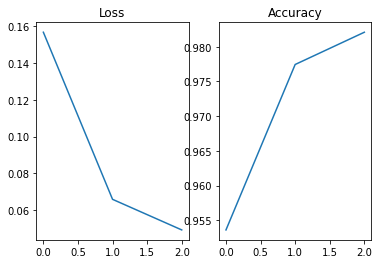

  0%|          | 0/625 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
# Initialize network
model = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

if load_model:
  load_checkpoint(torch.load('best.pth.tar'), model, optimizer)

train(train_loader, model)
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Create our model

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

Epoch 0: 100%|██████████| 625/625 [02:27<00:00,  4.24it/s]


Cost at epoch 0 is 0.617957928609848
Accuracy at epoch 0 is 0.7024


Epoch 1: 100%|██████████| 625/625 [02:11<00:00,  4.74it/s]


Cost at epoch 1 is 0.4691046716928482
Accuracy at epoch 1 is 0.78495


Epoch 2: 100%|██████████| 625/625 [02:11<00:00,  4.76it/s]


Cost at epoch 2 is 0.4012087921023369
Accuracy at epoch 2 is 0.8238


Epoch 3: 100%|██████████| 625/625 [02:10<00:00,  4.79it/s]


Cost at epoch 3 is 0.3273037399172783
Accuracy at epoch 3 is 0.85915


Epoch 4: 100%|██████████| 625/625 [02:10<00:00,  4.79it/s]


Cost at epoch 4 is 0.2840902366757393
Accuracy at epoch 4 is 0.87925


Epoch 5: 100%|██████████| 625/625 [02:11<00:00,  4.76it/s]


Cost at epoch 5 is 0.24146719697117805
Accuracy at epoch 5 is 0.8984


Epoch 6: 100%|██████████| 625/625 [02:10<00:00,  4.80it/s]


Cost at epoch 6 is 0.20453685656189918
Accuracy at epoch 6 is 0.91705


Epoch 7: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s]


Cost at epoch 7 is 0.1780993521556258
Accuracy at epoch 7 is 0.92735


Epoch 8: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s]


Cost at epoch 8 is 0.15847526737451553
Accuracy at epoch 8 is 0.9359


Epoch 9: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s]


Cost at epoch 9 is 0.12808025753349067
Accuracy at epoch 9 is 0.95065


Epoch 10: 100%|██████████| 625/625 [02:12<00:00,  4.73it/s]


Cost at epoch 10 is 0.11418696743100881
Accuracy at epoch 10 is 0.95445


Epoch 11: 100%|██████████| 625/625 [02:10<00:00,  4.78it/s]


Cost at epoch 11 is 0.10081901236474514
Accuracy at epoch 11 is 0.9602


Epoch 12: 100%|██████████| 625/625 [02:10<00:00,  4.80it/s]


Cost at epoch 12 is 0.0806293425116688
Accuracy at epoch 12 is 0.969


Epoch 13: 100%|██████████| 625/625 [02:11<00:00,  4.75it/s]


Cost at epoch 13 is 0.07400637347735464
Accuracy at epoch 13 is 0.97105


Epoch 14: 100%|██████████| 625/625 [02:10<00:00,  4.80it/s]


Cost at epoch 14 is 0.06505699325194582
Accuracy at epoch 14 is 0.97475


Epoch 15: 100%|██████████| 625/625 [02:09<00:00,  4.82it/s]


Cost at epoch 15 is 0.06598058563899249
Accuracy at epoch 15 is 0.975


Epoch 16: 100%|██████████| 625/625 [02:10<00:00,  4.79it/s]


Cost at epoch 16 is 0.051787456164322794
Accuracy at epoch 16 is 0.98085


Epoch 17: 100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


Cost at epoch 17 is 0.04909981537302956
Accuracy at epoch 17 is 0.98165


Epoch 18: 100%|██████████| 625/625 [02:09<00:00,  4.84it/s]


Cost at epoch 18 is 0.04504316457854584
Accuracy at epoch 18 is 0.9827


Epoch 19: 100%|██████████| 625/625 [02:09<00:00,  4.81it/s]


Cost at epoch 19 is 0.03853225134368986
Accuracy at epoch 19 is 0.9856


Epoch 20: 100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


Cost at epoch 20 is 0.04300565212899819
Accuracy at epoch 20 is 0.9848


Epoch 21: 100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


Cost at epoch 21 is 0.035118893851013855
Accuracy at epoch 21 is 0.9875


Epoch 22: 100%|██████████| 625/625 [02:09<00:00,  4.84it/s]


Cost at epoch 22 is 0.03101112913147081
Accuracy at epoch 22 is 0.9887


Epoch 23: 100%|██████████| 625/625 [02:09<00:00,  4.81it/s]


Cost at epoch 23 is 0.033752844780334273
Accuracy at epoch 23 is 0.9884


Epoch 24: 100%|██████████| 625/625 [02:10<00:00,  4.79it/s]


Cost at epoch 24 is 0.027338737085065803
Accuracy at epoch 24 is 0.98995


Epoch 25: 100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


Cost at epoch 25 is 0.026820335718919522
Accuracy at epoch 25 is 0.99035


Epoch 26: 100%|██████████| 625/625 [02:09<00:00,  4.82it/s]


Cost at epoch 26 is 0.028612083136988802
Accuracy at epoch 26 is 0.9889


Epoch 27: 100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


Cost at epoch 27 is 0.0330153198303422
Accuracy at epoch 27 is 0.988


Epoch 28: 100%|██████████| 625/625 [02:07<00:00,  4.89it/s]


Cost at epoch 28 is 0.02375127188519109
Accuracy at epoch 28 is 0.9909


Epoch 29: 100%|██████████| 625/625 [02:07<00:00,  4.91it/s]


Cost at epoch 29 is 0.023064396624083747
Accuracy at epoch 29 is 0.9923


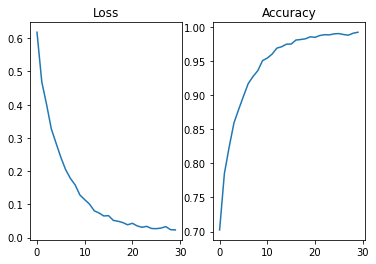

100%|██████████| 625/625 [01:46<00:00,  5.85it/s]


Accuracy on training set: 99.28


100%|██████████| 157/157 [00:27<00:00,  5.80it/s]

Accuracy on test set: 91.78


In [ ]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

if load_model:
  load_checkpoint(torch.load('best.pth.tar'), model, optimizer)

train(train_loader, model)
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

Epoch 0: 100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


Cost at epoch 0 is 0.6604419694350551
Accuracy at epoch 0 is 0.6863518370607029


Epoch 1: 100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Cost at epoch 1 is 0.46770235058217763
Accuracy at epoch 1 is 0.7869908146964856


Epoch 2: 100%|██████████| 313/313 [01:55<00:00,  2.70it/s]


Cost at epoch 2 is 0.39701008111143266
Accuracy at epoch 2 is 0.8261781150159745


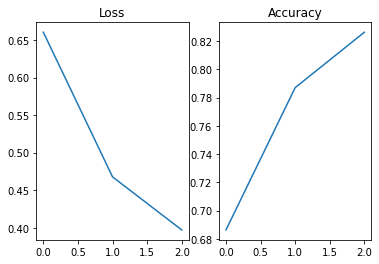

100%|██████████| 313/313 [01:37<00:00,  3.22it/s]


Accuracy on training set: 77.06


100%|██████████| 79/79 [00:24<00:00,  3.26it/s]

Accuracy on test set: 76.38


In [ ]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

if load_model:
  load_checkpoint(torch.load('best.pth.tar'), model, optimizer)

train(train_loader, model)
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

In [ ]:
class EfficientCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(EfficientCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(128 * 28 * 28, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

Epoch 0: 100%|██████████| 625/625 [02:06<00:00,  4.94it/s]


Cost at epoch 0 is 0.6531373206138611
Accuracy at epoch 0 is 0.60185


Epoch 1: 100%|██████████| 625/625 [02:11<00:00,  4.74it/s]


Cost at epoch 1 is 0.5795341919898986
Accuracy at epoch 1 is 0.69285


Epoch 2: 100%|██████████| 625/625 [02:07<00:00,  4.91it/s]


Cost at epoch 2 is 0.5378549431324006
Accuracy at epoch 2 is 0.72885


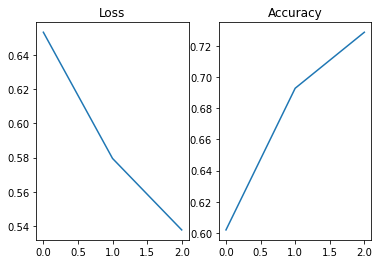

100%|██████████| 625/625 [01:52<00:00,  5.58it/s]


Accuracy on training set: 75.19


100%|██████████| 157/157 [00:28<00:00,  5.47it/s]

Accuracy on test set: 74.14


In [ ]:
# Initialize network
model = EfficientCNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

if load_model:
  load_checkpoint(torch.load('best.pth.tar'), model, optimizer)

train(train_loader, model)
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

In [ ]:
class CNN_V2(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CNN_V2, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv5 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 56 * 56, num_classes)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

Epoch 0: 100%|██████████| 625/625 [03:39<00:00,  2.85it/s]


Cost at epoch 0 is 2.0123689288616182
Accuracy at epoch 0 is 0.5887


Epoch 1: 100%|██████████| 625/625 [03:26<00:00,  3.03it/s]


Cost at epoch 1 is 0.6097247837543488
Accuracy at epoch 1 is 0.67285


Epoch 2: 100%|██████████| 625/625 [03:25<00:00,  3.05it/s]


Cost at epoch 2 is 0.5707703803062439
Accuracy at epoch 2 is 0.70545


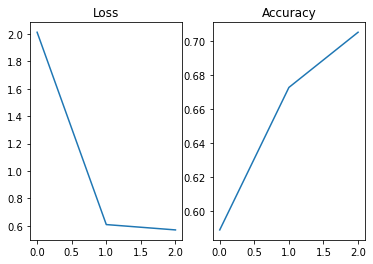

100%|██████████| 625/625 [01:53<00:00,  5.52it/s]


Accuracy on training set: 74.46


100%|██████████| 157/157 [00:29<00:00,  5.38it/s]

Accuracy on test set: 72.54


In [ ]:
# Initialize network
model = CNN_V2(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

if load_model:
  load_checkpoint(torch.load('best.pth.tar'), model, optimizer)

train(train_loader, model)
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

# Tensorflow


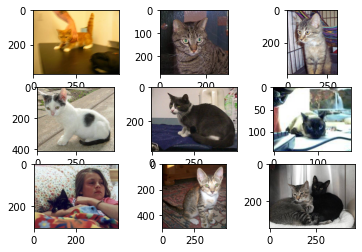

In [ ]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
# load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = 'train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
	# determine class
	output = 0.0
	if file.startswith('dog'):
		output = 1.0
	# load image
	photo = load_img(folder + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('dogs_vs_cats_photos.npy', photos)
save('dogs_vs_cats_labels.npy', labels)

(2487, 200, 200, 3) (2487,)


In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = ''
subdirs = ['train/', 'test1/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test1/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [ ]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(2, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('test1/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 4946 images belonging to 2 classes.
Found 1647 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


> 72.799
